# Выбор локации для скважины

## Описание проекта

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Описание данных

Данные о регионах находятся в трёх файлах
* geo_data_0.csv
* geo_data_1.csv
* geo_data_2.csv
* id - уникальный идентификатор скважины
* $f_i$ - признаки точек (неважно, что они обозначают, но сами признаки значимы)
* `product` - объём запасов в скважине (тыс баррелей)

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

from matplotlib_inline.backend_inline import set_matplotlib_formats
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse


set_matplotlib_formats('retina')

## Загрузка и подготовка данных

In [2]:
try:
    data_0 = pd.read_csv('geo_data_0.csv')
    data_1 = pd.read_csv('geo_data_1.csv')
    data_2 = pd.read_csv('geo_data_2.csv')
except: 
    data_0 = pd.read_csv('/datasets/geo_data_0.csv')
    data_1 = pd.read_csv('/datasets/geo_data_1.csv')
    data_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [4]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [5]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Пропусков в данных нет - уже хорошо :)

Посмотрим на распределение данных. Сделаю большую табличку сразу для всех данных, чтобы на графиках сразу сравнить все регионы

Пометим каждый из регионов просто цифрой

In [6]:
for (i, df) in enumerate([data_0, data_1, data_2]):
    df.loc[:, 'region'] = i

In [7]:
data = pd.concat((data_0, data_1, data_2), ignore_index=True)

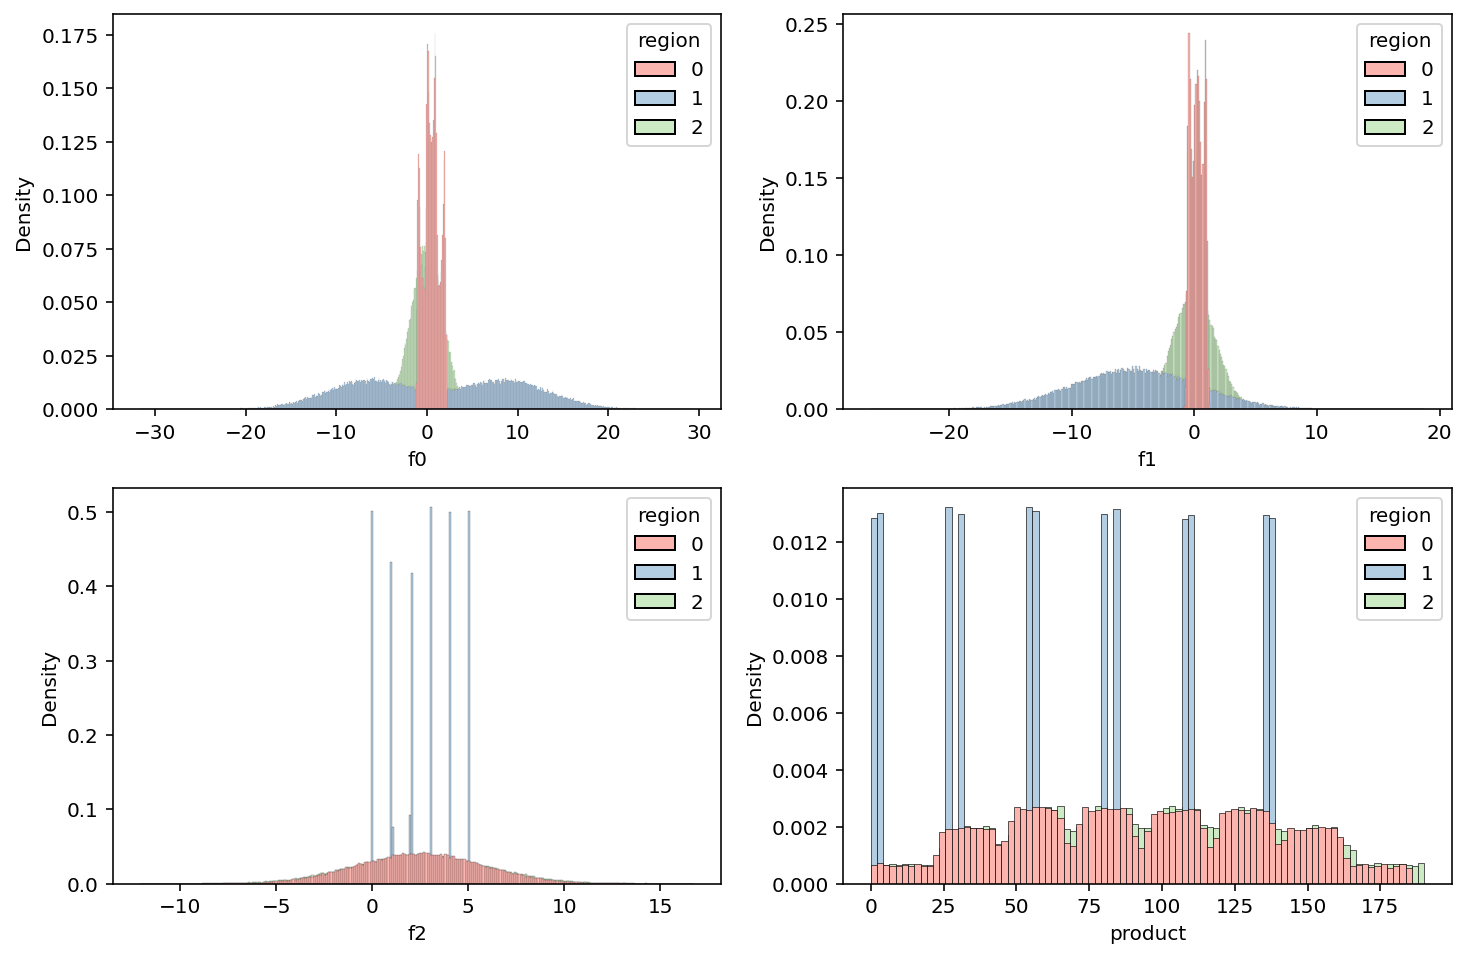

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
for axis, variable in zip(ax.flatten(), ['f0', 'f1', 'f2', 'product']):
    sns.histplot(ax=axis, 
                 data=data, 
                 x=variable, 
                 hue='region', 
                 palette='Pastel1', 
                 alpha=1, 
                 stat='density'
                )

Бросается в глаза распределения `f2` и `product` для региона `1`. Я бы сказал, что есть существует сильная зависимость между ними. Уж слишком они неестественными и похожими кажутся. Остальные данные это либо гаусс, либо комбинация нескольких гауссианов.

Посчитаем корреляции для наших регионов и проверим действительно ли существует связь между подмеченными мной величинами.

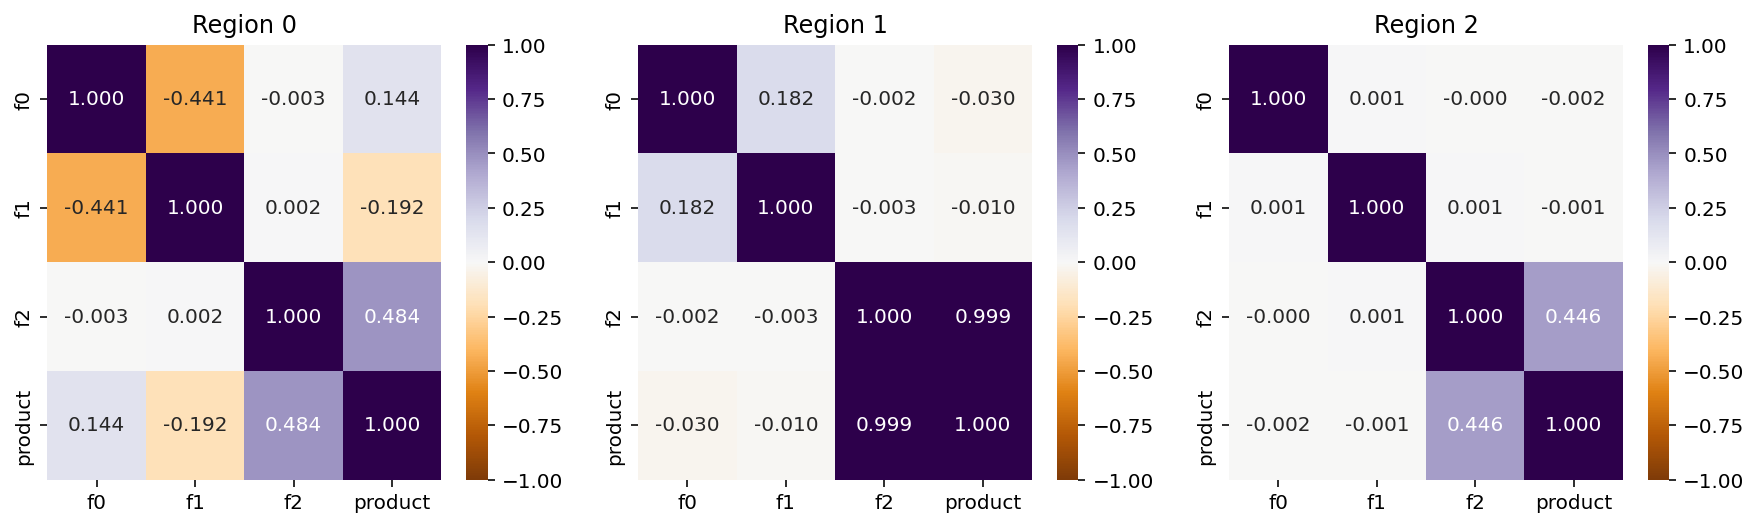

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
for i in range(3):
    tmp = data.query("region == @i").drop(['id', 'region'], axis=1)
    ax[i].set_title(f"Region {i}")
    sns.heatmap(ax=ax[i], data=tmp.corr(), annot=True, fmt=".3f", cmap=plt.cm.PuOr, vmin=-1, vmax=1)

Так и получилось между `f2` и `product` для региона `1` существует линейная зависимость. 
Впервые вижу, чтобы прямо почти единица была. Получается, что модель должна будет только на этот признак опираться при обучении, а остальные вообще не нужны. По крайней мере я жду, что около `f2` будет наибольший вес в модели, а у остальных около нуля. Если эти переменные были бы в признаках, то я бы убрал один из них, чтобы не было линейнозависимых переменных. А тут просто прямая связь... хотя может это и хорошо) Вот [тут](https://datascience.stackexchange.com/questions/94887/a-feature-highly-correlated-with-target-variable) советуют этот признак оставить.

Для других регионов также существует зависимость между этими величинами, но уже не такая выраженная как для первого региона. Помимо этого для нулевого и первого региона существует связь между `f1` и `f2`

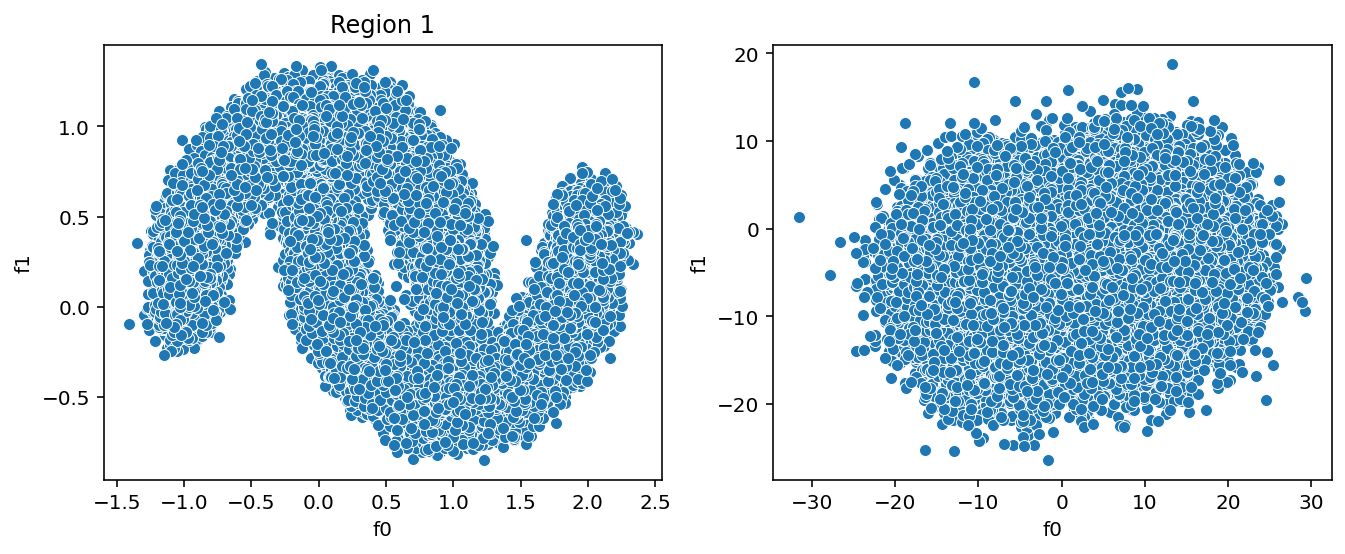

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(11, 4))
sns.scatterplot(ax=ax[0], data=data_0, x='f0', y='f1')
sns.scatterplot(ax=ax[1], data=data_1, x='f0', y='f1')

ax[0].set_title('Region 0')
ax[0].set_title('Region 1');

Ну да, зависимости есть, нелинейные, конечно, но есть 

Теперь отделим целевую переменную от основных данных

In [11]:
features_list = [data.loc[data['region'] == i].drop(['id', 'region', 'product'], axis=1) for i in range(3)]
target_list = [data.loc[data['region'] == i]['product'] for i in range(3)]

## Обучение и проверка модели

Здесь мы будем тренировать нашу линейную регрессию для предсказания количества нефти в скважине. Для каждого региона мы переобучаем модель, предварительно отмасшитабировав признаки. Для оценки будем выводить количество нефти в среднем для региона и корень среднеквадратичной ошибки

PS: пайплайн здесь особо не нужен, но я решил попрактиковаться на несложном примере

In [12]:
rmse = lambda y_true, y_pred: mse(y_true, y_pred)**0.5

In [13]:
pipe = Pipeline(
    steps=[
        ('scaler', StandardScaler()),
        ('linear_regression', LinearRegression()),
    ]
)

In [14]:
seed = 4
errors = []
lr_predictions = []
correct_target_values = []

for region in range(3):
    train_features, test_features, train_target, test_target = train_test_split(features_list[region], target_list[region], 
                                                                                test_size=0.25,
                                                                                random_state=seed
                                                                               )
    pipe.fit(train_features, train_target)
    lr_predictions.append(pipe.predict(test_features))
    correct_target_values.append(test_target)
    errors.append(rmse(lr_predictions[-1], test_target))
    print(f"Регион {region} Количество сырья: {lr_predictions[-1].mean():.2f} Ошибка: {errors[-1]:.2f}")

Регион 0 Количество сырья: 92.36 Ошибка: 37.71
Регион 1 Количество сырья: 69.21 Ошибка: 0.89
Регион 2 Количество сырья: 95.14 Ошибка: 40.01


Сделаем небольшую табличку для удобства оценки результатов

In [15]:
lr_predictions = np.array(lr_predictions)

In [16]:
check_table = data.groupby('region')['product'].agg(true="mean")
check_table['LR'] = lr_predictions.mean(axis=1)

In [17]:
check_table.reset_index()

,region,true,LR
0,0,92.500,92.359194
1,1,68.825,69.209553
2,2,95.000,95.138416


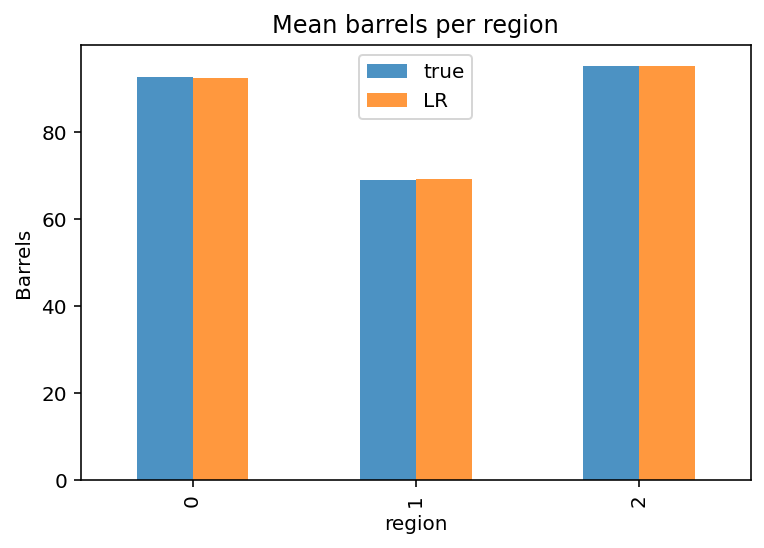

In [18]:
check_table.plot(kind='bar', alpha=0.8)
plt.title("Mean barrels per region")
plt.ylabel("Barrels");

В среднем результаты хорошие вышли, но для 0 и второго региона ошибка огромная, почти половина от среднего значения. По идее, можно проверить нашу модель следующим образом, если линейная модель хорошо подходит для описания, то когда я построю целевую переменную от предсказанных значений, то выйдет прямая под 45 градусов

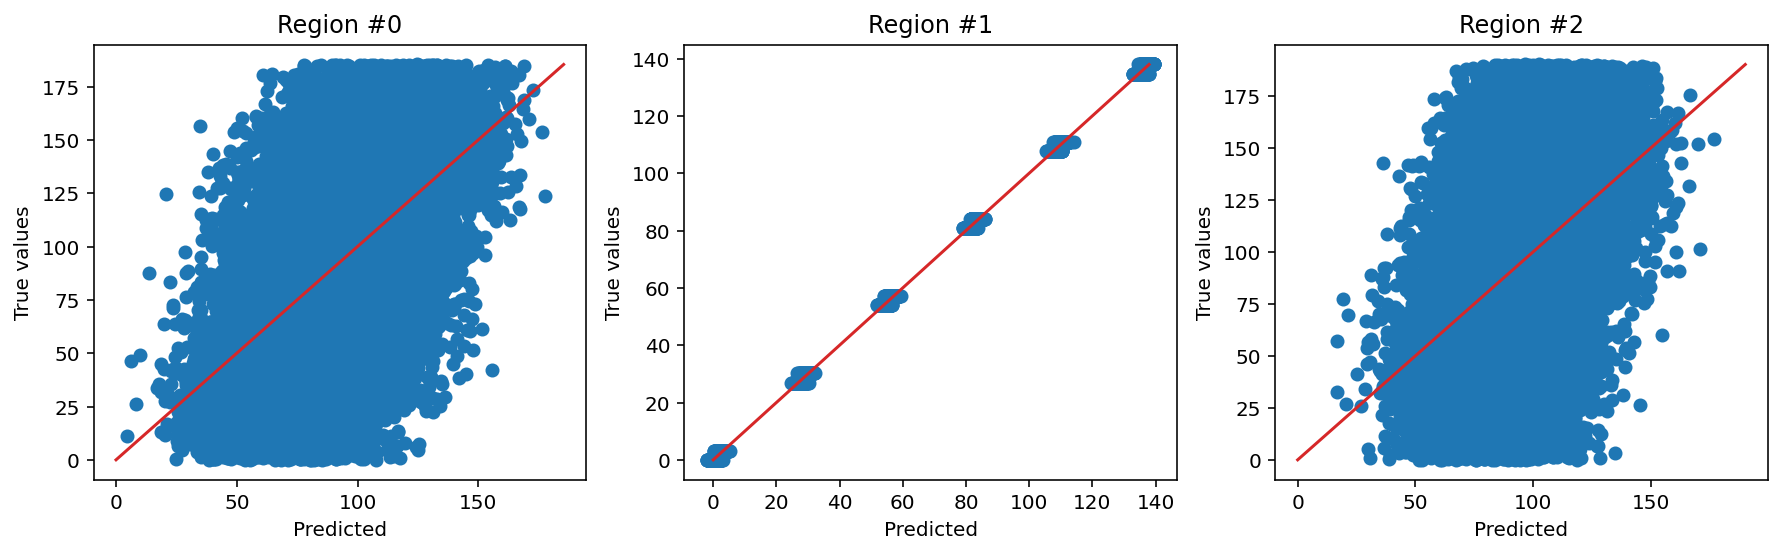

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
for i in range(3):
    ax[i].set(
        title=f"Region #{i}",
        ylabel='True values',
        xlabel='Predicted'
    )
    ax[i].scatter(lr_predictions[i], correct_target_values[i])
    ax[i].plot(correct_target_values[i].sort_values(), correct_target_values[i].sort_values(), color='tab:red')

Видно, что линейная регрессия не лучший выбор, но по условию мы на другие модели не смотрим ¯\_(ツ)_/¯ 

## Подготовка к расчёту прибыли

Итак, по условию нам дано
* `BUDGET` - бюджет на разработку 10 млрд 
* `PROFIT_PER_UNIT` - доход с одного барреля нефти - 450 тысяч
* `SAMPLES_TO_BUILD` - планируем строить 200 скважин
* `SAMPLES_SIZE` - параметр для бутстапирования, будет делать выборки по 500 скважин

In [21]:
BUDGET = 1e10
PROFIT_PER_UNIT = 450_000
SAMPLES_SIZE = 500
SAMPLES_TO_BUILD = 200

Посчитем сколько должна приносит одна скважина в среднем, чтобы наша кампания окупилась

In [25]:
should_score = BUDGET / (SAMPLES_TO_BUILD * PROFIT_PER_UNIT)
print(f"Mean barrels per unit: {should_score:.3f}")

Mean barrels per unit: 111.111


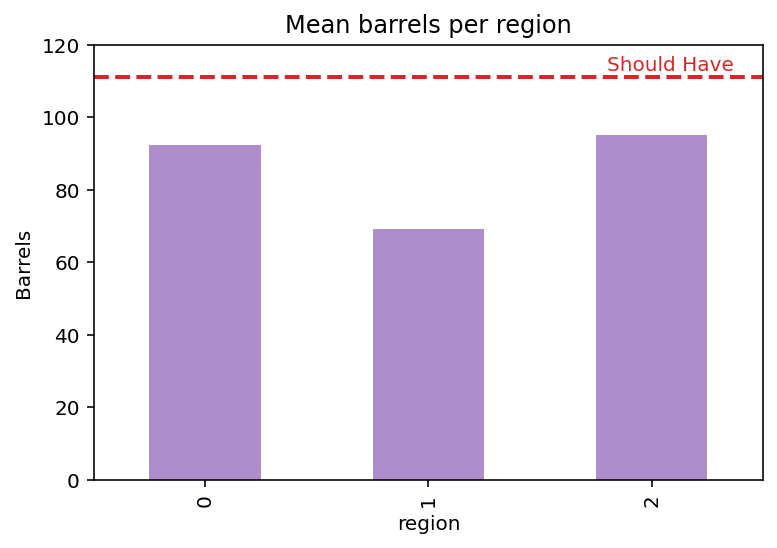

In [26]:
check_table[['LR']].plot(kind='bar', legend=False, color='tab:purple', alpha=0.75)
plt.hlines(should_score, -0.5, 2.5, lw=2, color='tab:red', ls='--')
plt.annotate("Should Have", (1.8, 113), color='tab:red')
plt.ylim(0, 120)
plt.ylabel("Barrels")
plt.title("Mean barrels per region");

То есть в среднее значение по добычи нефти в каждом из регионов ниже чем нам нужно, чтобы получать прибыль. Но это в среднем

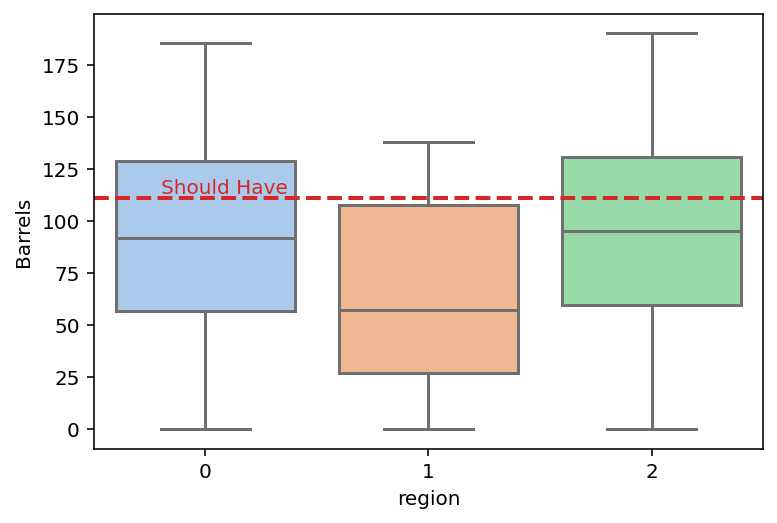

In [27]:
sns.boxplot(data=data, x='region', y='product', palette='pastel')
plt.hlines(should_score, -0.5, 2.5, lw=2, color='tab:red', ls='--')
plt.annotate("Should Have", (-0.2, 113), color='tab:red')
plt.ylabel("Barrels");

Вот отсюда уже видно, что в регионах 0 и 2 с чем более 25% скважин, то есть более 25000 штук, можно добывать необходимое количество нефти. В регионе 1 этот показатель похуже, около 23% я бы сказал, но уже видно, что скорее всего этот регион не должен быть выбран. Его самые объемные месторождения уступают регионам 0 и 2 и количество достаточно объемных скважин также ниже, чем в двух других локациях

## Расчёт прибыли и рисков 

Пора оценить возможную прибыль и риски при бурении наших скважин. Напишим две функции:

1) `profit_evaluate` будет рассчитывать прибыль лучших 200 скважин

2) `bootstrap_procedure` проводить процедуру бутстрапирования, то есть генерирует `n_samples` выборок по 500 единиц в каждой

In [28]:
def profit_evaluate(y_true, y_predict):
    index = np.argsort(y_predict)[-SAMPLES_TO_BUILD:]
    profit = PROFIT_PER_UNIT * y_true[index].sum() - BUDGET
    return profit

In [29]:
def bootstrap_procedure(y_true: np.array, y_predict: np.array, n_samples: int, random_state: int) -> np.array:
    np.random.seed(seed)
    indexes = np.random.choice(np.arange(y_predict.size), size=(n_samples, SAMPLES_SIZE))
    mapped_values = map(profit_evaluate, y_true[indexes], y_predict[indexes])
    return np.array(list(mapped_values))
    

In [30]:
for i in range(3):
    region_profit = bootstrap_procedure(correct_target_values[i].values, lr_predictions[i], 1000, seed)
    print(f"Прибыль с региона {i}: {region_profit.mean() / 1e06:.3f} млн")
    print(f"Доверительный интервал, 95%: [{np.quantile(region_profit, 0.025) / 1e06:.3f}, {np.quantile(region_profit, 0.975) / 1e06:.3f}]")
    print(f"Риск убытков {(region_profit < 0).mean():.1%}", end='\n\n')

Прибыль с региона 0: 396.870 млн
Доверительный интервал, 95%: [-102.184, 895.476]
Риск убытков 6.1%

Прибыль с региона 1: 499.797 млн
Доверительный интервал, 95%: [122.979, 885.975]
Риск убытков 0.9%

Прибыль с региона 2: 362.128 млн
Доверительный интервал, 95%: [-184.469, 857.230]
Риск убытков 9.2%



Получается, что нужно выбирать регион 1. о_О... я не согласен) Здесь мы выбирали по предсказаниям модели, которая сильно ошибается на 0 и 2 регионах, то есть на двух из трех предложенных. Раз уж мне доступны правильные ответы, то можно сделать проверку. 

__Однако__ В будущем реальные значения будут неизвестны, так что выше все сделано корректно, а ниже некорректно. При этом добывать мы будем столько, сколько там есть на самом деле, а не столько, сколько предсказали. Поэтому сейчас то посмотреть можно😅 (закоменченный код), но вывод все равно по качеству модели нужно делать


PS: Кстати, здесь видно, что средняя прибыль с региона - это полусумма нашего доверительного интервала. Это вроде получается из-за бутстрапирования и цпт, то есть получаемые распределения описываются гауссианом

Итак, предположим, что наша модель угадала в точности все ответы для каждого региона, то есть в коде нужно поменять `lr_prediction` на `correct_target_values`. Посмотрим на наши результаты в этом случае

In [31]:
# for i in range(3):
#     region_profit = bootstrap_procedure(correct_target_values[i].values, correct_target_values[i].values, 1000, seed)
#     print(f"Прибыль с региона {i}: {region_profit.mean() / 1e06:.3f} млн")
#     print(f"Доверительный интервал, 95%: [{np.quantile(region_profit, 0.025) / 1e06}, {np.quantile(region_profit, 0.975) / 1e06}]")
#     print(f"Риск убытков {(region_profit < 0).mean():.1%}", end='\n\n')

Прибыль с региона 0: 2379.171 млн
Доверительный интервал, 95%: [1996.8424174954348, 2756.1595015238727]
Риск убытков 0.0%

Прибыль с региона 1: 500.614 млн
Доверительный интервал, 95%: [122.99796518155027, 885.9753285040864]
Риск убытков 0.9%

Прибыль с региона 2: 2620.488 млн
Доверительный интервал, 95%: [2236.789573767237, 2995.6234982233163]
Риск убытков 0.0%



В этом случае результаты сильно разнятся с тем, что мы имеет при использовании действительных предсказаний линейной модели. Выходит, что если бы подобрали более лучшую модель первый регион мы бы не рассматривали совсем.

## Вывод

В данном проекте по предложенным данным о свойствах нефтяных скважин для трех регионов мы должны были выбрать наиболее прибыльный регион.
В качестве модели для оценки количества сырья в каждой из скважин была рекомендована линейная регрессия, которая хорошо сработала лишь для одного из трех регионов. 

Согласно плану для исследования нам доступно до 500 скважин, при этом нужно отобрать из них 200 лучших, которые и будут впоследствии разрабатываться. Расчеты показали, что при имеющемся бюджете в 10 млрд рублей в среднем каждая из скважин должна приносить 111.1(1) тысяч баррелей нефти. 

Используя предсказанные нашей моделью величины запасов сырья, мы проанализировали 500 скважин для каждого региона с применением  техники бутстрапирования (1000 выборок по 500 скважин для каждого региона). По результатам расчетов наиболее выгодным получился регион номер 1. По оценкам этот регион способен приносить 499.797 млн. 